In [71]:
import os
import pandas as pd
import sqlalchemy
import sklearn
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

connection_string = os.getenv("LINODE_CONN_STRING")
connection_string = os.getenv("LINODE_CONN_STRING")
conn = sqlalchemy.create_engine(os.getenv("LINODE_CONN_STRING")).connect()

In [72]:
data = pd.read_sql("select * from sports_data.tourney_games_with_season_stats", conn)

In [73]:
data['Win_Loss_Flag'] = data['Win_Loss'].apply(lambda x: 1 if x == 'W' else 0)

In [74]:
predictor_columns = data.columns[8:-1]
predictors = data[predictor_columns]
predictors_and_response = pd.concat([predictors, data['Win_Loss_Flag']], axis=1)

In [75]:
predictors_and_response.corr(numeric_only=True)['Win_Loss_Flag'].sort_values(ascending=False)

Win_Loss_Flag                                  1.000000
adj_offense_team                               0.270970
adj_defense_opponent                           0.225174
offensive_efficiency_team                      0.196490
opponent_offensive_efficiency_opponent         0.123610
effective_fg_percent_team                      0.116454
opponent_effective_fg_percent_opponent         0.112050
turnover_percent_opponent                      0.106504
offensive_rebound_percent_team                 0.104910
opponent_free_throw_rate_opponent              0.070684
free_throw_rate_opponent                       0.066086
opponent_turnover_percent_team                 0.033527
opponent_offensive_rebound_percent_opponent    0.001040
opponent_offensive_rebound_percent_team       -0.001040
opponent_turnover_percent_opponent            -0.033527
free_throw_rate_team                          -0.066086
opponent_free_throw_rate_team                 -0.070684
offensive_rebound_percent_opponent            -0

In [76]:
corrs = predictors_and_response.corr(numeric_only=True)['Win_Loss_Flag']
corrs = corrs[corrs > 0.02]
corrs = corrs[corrs.index != 'Win_Loss_Flag']
effective_predictors = corrs.index.tolist()

In [77]:
len(effective_predictors)

11

In [78]:
prediction_data = data[effective_predictors]
prediction_data_normalized = (prediction_data-prediction_data.mean())/prediction_data.std()

In [79]:
prediction_data_normalized

,adj_offense_team,offensive_efficiency_team,effective_fg_percent_team,offensive_rebound_percent_team,opponent_turnover_percent_team,adj_defense_opponent,turnover_percent_opponent,free_throw_rate_opponent,opponent_offensive_efficiency_opponent,opponent_effective_fg_percent_opponent,opponent_free_throw_rate_opponent
0,-0.927835,-1.624681,-1.649647,-0.387095,0.617680,-0.591715,-0.114575,-0.058197,-0.464621,0.068223,-0.223741
1,-0.212381,-0.766889,-0.859129,0.315748,1.201215,-0.385921,-0.239694,-0.604433,-0.172103,-0.505183,0.359243
2,-0.195177,-0.715680,-0.196766,-0.101264,0.512527,-0.642958,0.836021,-0.578729,-0.571980,-0.983478,1.185184
3,1.053736,0.897114,0.248055,1.953495,0.069976,-0.749431,0.594703,0.817571,-0.412882,-0.499381,1.303525
4,-0.195177,-0.715680,-0.196766,-0.101264,0.512527,-0.790995,0.111636,-0.887965,-0.300158,-0.272603,-0.055341
...,...,...,...,...,...,...,...,...,...,...,...
1237,-1.426319,-0.604308,-0.281490,-0.531916,0.416185,0.157309,-0.374213,0.576946,0.324425,0.265386,1.252496
1238,0.367438,0.559941,1.489443,-1.255623,0.119701,0.328140,0.726266,1.420357,-0.523980,-0.440797,-0.824305
1239,-1.387000,-1.206570,-0.153137,-2.031117,-0.428632,-0.632140,0.312622,1.204664,-1.084201,-1.145650,-0.827130
1240,0.519922,0.775015,0.189707,0.712305,0.844513,0.025232,0.429733,0.886730,0.583046,0.949030,0.558894


In [80]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [81]:
data['predicted_outcome'] = clf.predict(prediction_data_normalized)

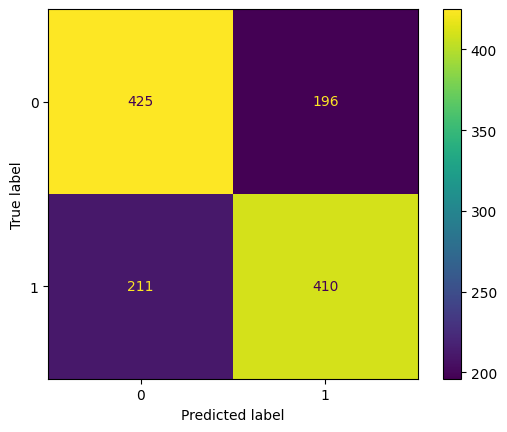

In [82]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], data['predicted_outcome'])).plot()

Logistic regression predicted 835 games correctly and got 407 wrong. Getting about 2/3 of the games right is not bad, but it's not great either. Other models might yield better results.

In [83]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(random_state=0, max_iter=3000).fit(prediction_data_normalized, data['Win_Loss_Flag'])

In [84]:
data['nn_predicted_outcome'] = clf.predict(prediction_data_normalized)

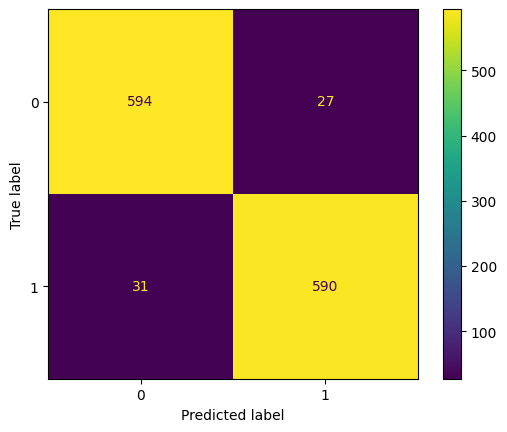

In [85]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(data['Win_Loss_Flag'], data['nn_predicted_outcome'])).plot()

NN did a lot better but there's probably some overfitting happening. Need to hold out a test set.

In [86]:
train_X = prediction_data_normalized.iloc[:int(len(prediction_data_normalized)*0.6)]
train_y = data['Win_Loss_Flag'].iloc[:int(len(prediction_data_normalized)*0.6)]
test_X = prediction_data_normalized.iloc[int(len(prediction_data_normalized)*0.6):]
test_y = data['Win_Loss_Flag'].iloc[int(len(prediction_data_normalized)*0.6):]

In [87]:
clf = MLPClassifier(hidden_layer_sizes=[50, 50, 50],random_state=0, max_iter=3000).fit(train_X, train_y)

In [88]:
nn_test_outcomes = clf.predict(test_X)

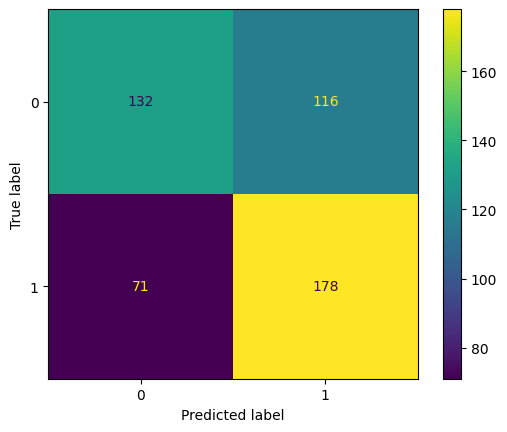

In [89]:
sklearn.metrics.ConfusionMatrixDisplay(sklearn.metrics.confusion_matrix(test_y, nn_test_outcomes)).plot()

In [90]:
def proper_cross_validation(clf, X, y, k=5):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=k)
    confusion_matrices = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        clf.fit(X_train, y_train)
        confusion_matrices.append(sklearn.metrics.confusion_matrix(y_test, clf.predict(X_test)))
    total_confusion_matrix = sum(confusion_matrices)
    return total_confusion_matrix

In [91]:
cms = proper_cross_validation(MLPClassifier(hidden_layer_sizes=[50, 50, 50],random_state=0, max_iter=3000), prediction_data_normalized, data['Win_Loss_Flag'])

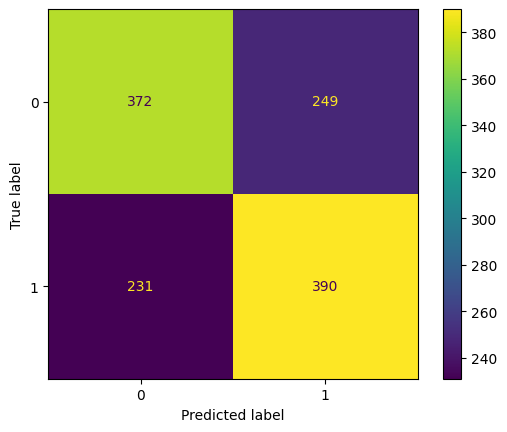

In [92]:
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

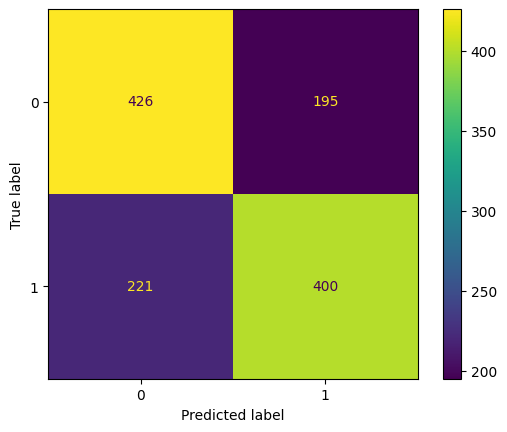

In [93]:
# and what about the logistic regression model?
cms = proper_cross_validation(LogisticRegression(random_state=0), prediction_data_normalized, data['Win_Loss_Flag'])
sklearn.metrics.ConfusionMatrixDisplay(cms).plot()

In [94]:
# well, they're both getting things right a little under 70% of the time
# could try different models, but better indicators is probably the more effective way to go
all_games = pd.read_sql("select * from sports_data.game_stats_v2", conn)

In [95]:
all_games.columns

Index(['date', 'game_type', 'team', 'conference', 'opponent', 'location',
       'result', 'adj_offense', 'adj_defense', 'offensive_efficiency',
       'effective_fg_percent', 'turnover_percent', 'offensive_rebound_percent',
       'free_throw_rate', 'opponent_offensive_efficiency',
       'opponent_effective_fg_percent', 'opponent_turnover_percent',
       'opponent_offensive_rebound_percent', 'opponent_free_throw_rate',
       'opponent_conference', 'season', 'Win_Loss', 'score', 'opponent_score'],
      dtype='object')

In [96]:
team_conference_affiliation = all_games[['team', 'conference', 'season']].drop_duplicates(subset=['team', 'season'], keep='first')

In [97]:
len(data.columns)

35

In [99]:
data = pd.merge(data, team_conference_affiliation, left_on=['team', 'season'], right_on=['team', 'season'])

In [101]:
data['conference']

0       P12
1       B12
2       SEC
3        BE
4       SEC
       ... 
1237     SC
1238    MVC
1239    MWC
1240    P12
1241     BE
Name: conference, Length: 1242, dtype: object